In [1]:
import seaborn as sns
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)

# 第二章 机器学习进阶

本章依赖的python类库有：

- numpy 快速操作结构数组的工具
- pandas 数据分析处理工具
- matplotlib 画图工具
- sklearn 机器学习库
- seaborn 基于matplotlib封装的统计绘图工具
- abupy 开源的量化系统，内含ml_fit机器学习模块，[abupy开源地址](https://github.com/bbfamily/abu)，[abupy环境搭建教程](http://www.abuquant.com/lecture/lecture_0.html)
- xgboost boost的一种实现类库 见2.6 模型融合-Boosting：GBDT

安装教程见实体书附录A，每个小节可以独立运行。

____

## 2.1 特征工程

### 泰坦尼克号生成预测


In [2]:
import pandas as pd # pandas是python的数据格式处理类库

# 加载泰坦尼克号生存预测数据集
data_train = pd.read_csv("./data/titanic/train.csv")
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
data_train.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


In [4]:
data_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 两类特征

#### 处理数据缺失


In [5]:
def set_missing_ages(p_df):
    p_df.loc[(p_df.Age.isnull()), 'Age'] = p_df.Age.dropna().mean()
    return p_df
df = set_missing_ages(data_train)

#### 归一化数值数据

In [6]:
import sklearn.preprocessing as preprocessing

scaler = preprocessing.StandardScaler()
df['Age_scaled'] = scaler.fit_transform(data_train['Age'])
df['Fare_scaled'] = scaler.fit_transform(data_train['Fare'])

/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if

#### 处理类别意义的特征


In [7]:
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df
df = set_cabin_type(df)

In [8]:
dummies_pclass = pd.get_dummies(data_train['Pclass'], prefix='Pclass')
dummies_pclass.head(3)

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1


In [9]:
dummies_embarked = pd.get_dummies(data_train['Embarked'], prefix='Embarked')
dummies_embarked.loc[61]

Embarked_C    0
Embarked_Q    0
Embarked_S    0
Name: 61, dtype: uint8

In [10]:
dummies_sex = pd.get_dummies(data_train['Sex'], prefix='Sex')
dummies_sex.head(3)

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0


In [11]:
df = pd.concat([df, dummies_embarked, dummies_sex, dummies_pclass], axis=1)

# noinspection PyUnresolvedReferences
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

In [12]:
# 选择哪些特征作为训练特征
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_df.head(1)

,Survived,SibSp,Parch,Age_scaled,Fare_scaled,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,1,0,-0.592481,-0.502445,0,0,1,0,1,0,0,1


In [13]:
from abupy import AbuML

train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
titanic = AbuML(x, y, train_df)

titanic.estimator.logistic_classifier()
titanic.cross_val_accuracy_score()

LogisticRegression score mean: 0.7991973101804563


array([ 0.7778,  0.7889,  0.7753,  0.8202,  0.7865,  0.7753,  0.7865,
        0.7978,  0.8315,  0.8523])

### 构造非线性特征


In [14]:
# 划分区间
df['Child'] = (data_train['Age'] <= 10).astype(int)
# 平方
df['Age*Age'] = data_train['Age'] * data_train['Age']
# 归一化
df['Age*Age_scaled'] = scaler.fit_transform(df['Age*Age'])

In [15]:
df['Age*Class'] = data_train['Age'] * data_train['Pclass']
# 归一化
df['Age*Class_scaled'] = scaler.fit_transform(df['Age*Class'])

In [16]:
# filter加入新增的特征
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*|Child|Age\*Class_.*')
train_df.head(1)

,Survived,SibSp,Parch,Age_scaled,Fare_scaled,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Child,Age*Age_scaled,Age*Class_scaled
0,0,1,0,-0.5925,-0.5024,0,0,1,0,1,0,0,1,0,-0.6366,0.0314


In [17]:
train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
titanic = AbuML(x, y, train_df)

titanic.estimator.logistic_classifier()
titanic.cross_val_accuracy_score()

LogisticRegression score mean: 0.8047522982635342


array([ 0.8   ,  0.8   ,  0.7865,  0.8427,  0.7978,  0.764 ,  0.7978,
        0.7865,  0.8427,  0.8295])

#### 评估特征作用


In [18]:
titanic.importances_coef_pd()

,coef,columns
0,[-0.410297985753],SibSp
1,[-0.173336553717],Parch
2,[-0.208458001682],Age_scaled
3,[0.16557734118],Fare_scaled
4,[0.0],Embarked_C
5,[0.0],Embarked_Q
6,[-0.405822303619],Embarked_S
7,[1.99640247637],Sex_female
8,[-0.715926431858],Sex_male
9,[0.663402660113],Pclass_1


In [19]:
titanic.feature_selection()

RFE selection
                  ranking support
SibSp                   1    True
Parch                   3   False
Age_scaled              2   False
Fare_scaled             4   False
Embarked_C              9   False
Embarked_Q              8   False
Embarked_S              1    True
Sex_female              1    True
Sex_male                1    True
Pclass_1                1    True
Pclass_2                7   False
Pclass_3                1    True
Child                   1    True
Age*Age_scaled          6   False
Age*Class_scaled        5   False


,ranking,support
SibSp,1,True
Parch,3,False
Age_scaled,2,False
Fare_scaled,4,False
Embarked_C,9,False
Embarked_Q,8,False
Embarked_S,1,True
Sex_female,1,True
Sex_male,1,True
Pclass_1,1,True


## 2.2 调试模型

### 模型调试的目标

In [20]:
# L2正则化
# X是训练样本矩阵，W是权重矩阵，b是偏置向量，y是真实标签矩阵
def loss_func(X, W, b, y):
    # lmd 是一个可调节的模型参数
    C = 2
    s = score(X, W, b)
    p = softmax(s)
    return -np.mean(cross_entropy(y, p)) + np.mean(np.dot(w.T, w) / C)

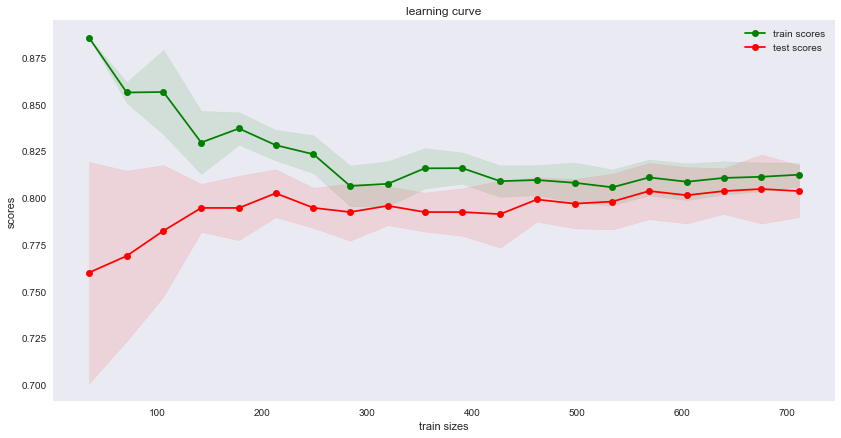

In [21]:
from abupy import AbuML

# create_test_more_fiter用于快速测试API，封装了titanic数据集合相关的特征处理
titanic = AbuML.create_test_more_fiter()
titanic.estimator.logistic_classifier()

# 学习曲线
titanic.plot_learning_curve()

### 调试模型

#### 待调试的模型参数

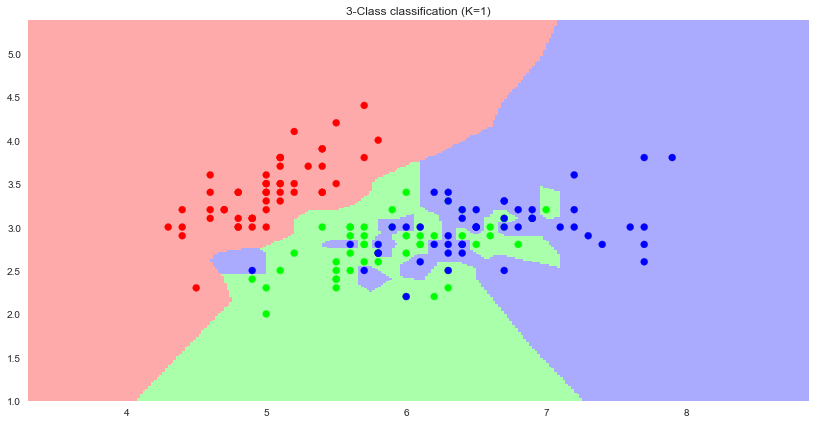

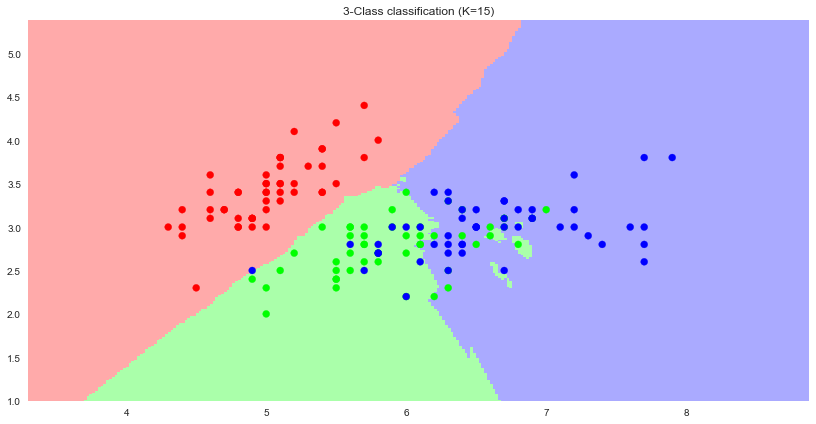

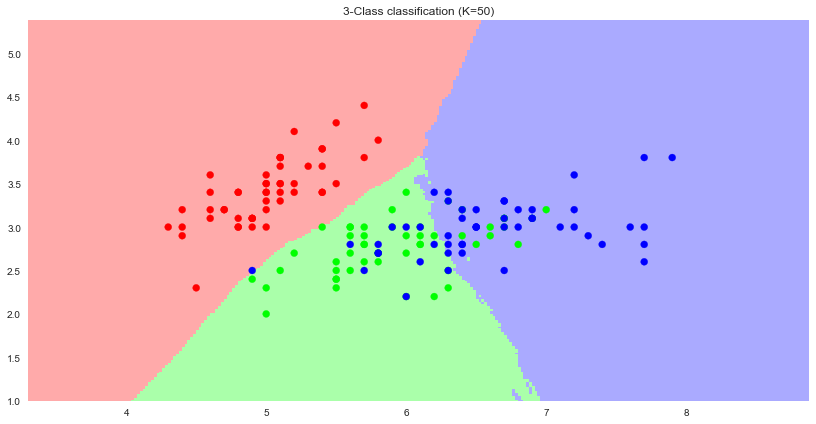

In [22]:
# 不同k值下的分类效果比较
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

# 获取iris数据集
iris = datasets.load_iris()

# create X and y
X = iris.data
y = iris.target

n_neighbors = [1, 15, 50]

X_plot = X[:, :2]  # 只取前两维特征，方便plot

h = .02  # plot网格单位长

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for k in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_plot, y)
    y_pred = clf.predict(X_plot)

    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # 用 color plot 观察分类结果
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # plot训练样本点
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y, cmap=cmap_bold)
    plt.title("3-Class classification (K={})".format(k))
    plt.axis('tight')
    # plt.savefig('knn_k_{}.png'.format(k))

plt.show()

####  交叉验证（Cross-validation）

In [23]:
# IRIS花卉数据集
iris = AbuML.create_test_fiter()

# 使用KNN
iris.estimator.knn_classifier()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [24]:
from abupy import KFold

kf = KFold(len(iris.y), n_folds=10, shuffle=True)

for train_index, test_index in kf:
    x_train, x_test = iris.x[train_index], iris.x[test_index]
    y_train, y_test = iris.y[train_index], iris.y[test_index]
    
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((135, 4), (15, 4), (135,), (15,))

#### GridSearch

start grid search please wait...


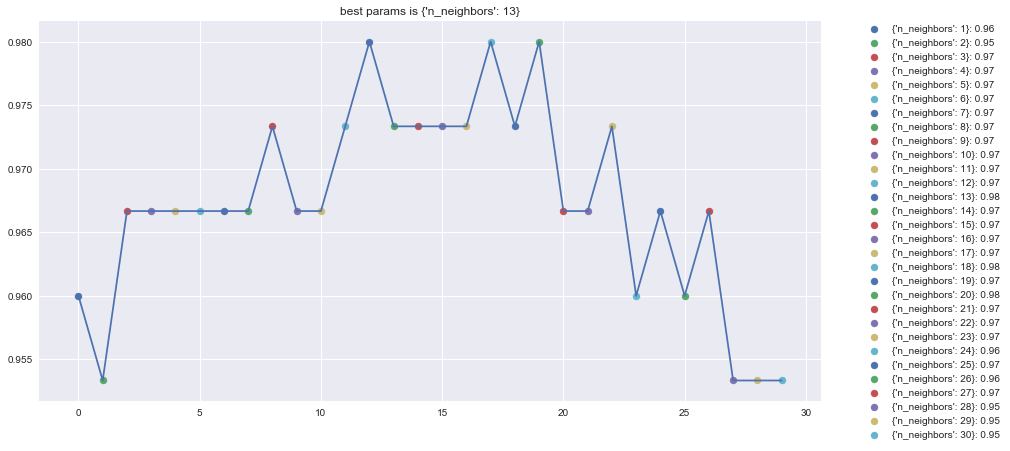

{'n_neighbors': 13}

In [25]:
from abupy import ABuMLGrid
# 定义参数搜索范围
param_grid = dict(n_neighbors=range(1, 31))

# grid seach
#best_score_, best_params_ = iris.grid_search_common_clf(param_grid, cv=10, scoring='accuracy')
#best_score_, best_params_
_, best_params = ABuMLGrid.grid_search_mul_init_kwargs(iris.estimator.clf, iris.x, iris.y, scoring='accuracy',
                                                                param_grid=param_grid, show=True)
best_params

In [26]:
# Titanic处理好的数据集
titanic = AbuML.create_test_more_fiter()

# 使用逻辑分类
titanic.estimator.logistic_classifier()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

start grid search please wait...


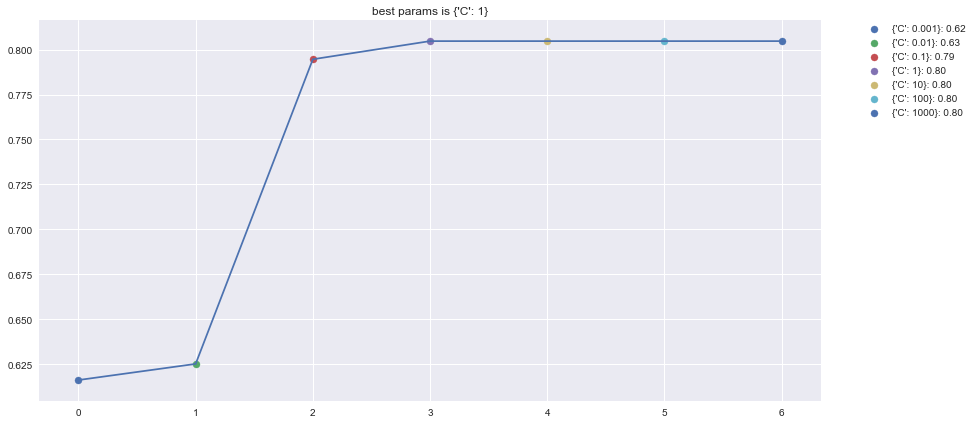

{'C': 1}

In [27]:
# 定义参数搜索范围
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

_, best_params = ABuMLGrid.grid_search_mul_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
                                                                       param_grid=param_grid, show=True)
best_params

## 2.3 分类模型评估指标

### 混淆矩阵系指标

#### 混淆矩阵(Confusion Matrix)

In [28]:
from abupy import AbuML

# 泰坦尼克号生存预测
titanic = AbuML.create_test_more_fiter()

[[491  58]
 [100 242]]


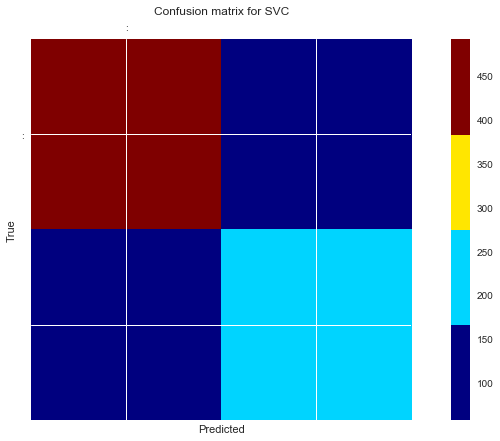

In [29]:
titanic.plot_confusion_matrices()

In [30]:
from abupy import ABuMLExecute
from sklearn import metrics

titanic_y_pred = ABuMLExecute.run_cv_estimator(titanic.get_fiter(), titanic.x, titanic.y, n_folds=10)
confusion_matrix = metrics.confusion_matrix(titanic.y, titanic_y_pred)
TP = confusion_matrix[1, 1]
TN = confusion_matrix[0, 0]
FP = confusion_matrix[0, 1]
FN = confusion_matrix[1, 0]
TP, TN, FP, FN

(245, 489, 60, 97)

#### 准确率(Accuracy)

In [31]:
assert metrics.accuracy_score(titanic.y, titanic_y_pred) == (TP + TN) / float(TP + TN + FP + FN)

#### 精确率和召回率(Precision-Recall)


In [32]:
# “生存”类别的精确率
tit_precision = TP / float(TP + FP)
# “生存”类别的召回率
tit_recall = TP / float(TP + FN)

assert metrics.precision_score(titanic.y, titanic_y_pred) == tit_precision
assert metrics.recall_score(titanic.y, titanic_y_pred) == tit_recall

#### F1分数(F1-Score)


In [33]:
assert metrics.f1_score(titanic.y, titanic_y_pred) == 2 * tit_precision * tit_recall / (tit_precision + tit_recall)

#### 多分类的指标


In [34]:
# IRIS花卉数据集
iris = AbuML.create_test_fiter()
iris.estimator.knn_classifier(n_neighbors=20)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

[[50  0  0]
 [ 0 47  3]
 [ 0  5 45]]


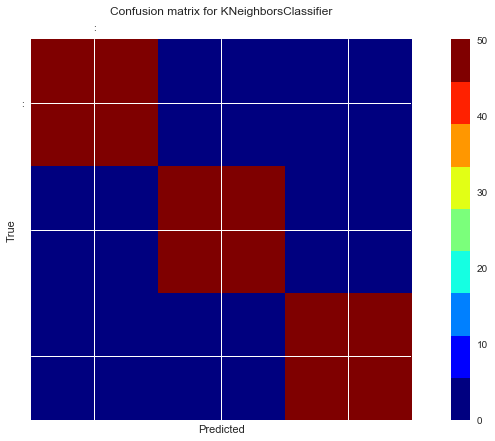

In [35]:
confusion = iris.plot_confusion_matrices()

In [36]:
iris_y_pred = ABuMLExecute.run_cv_estimator(iris.get_fiter(), iris.x, iris.y, n_folds=10)
# precision
metrics.precision_score(iris.y, iris_y_pred, average=None)

array([ 1.    ,  0.9412,  0.9592])

In [37]:
# recall
metrics.recall_score(iris.y, iris_y_pred, average=None)

array([ 1.  ,  0.96,  0.94])

In [38]:
# f1-score
metrics.f1_score(iris.y, iris_y_pred, average=None)

array([ 1.    ,  0.9505,  0.9495])

In [39]:
print(metrics.precision_score(iris.y, iris_y_pred, average=None))
print(metrics.recall_score(iris.y, iris_y_pred, average='macro'))
print(metrics.f1_score(iris.y, iris_y_pred, average='weighted'))

[ 1.      0.9412  0.9592]
0.966666666667
0.966663333


### 评估曲线

#### ROC曲线

ROC曲线：

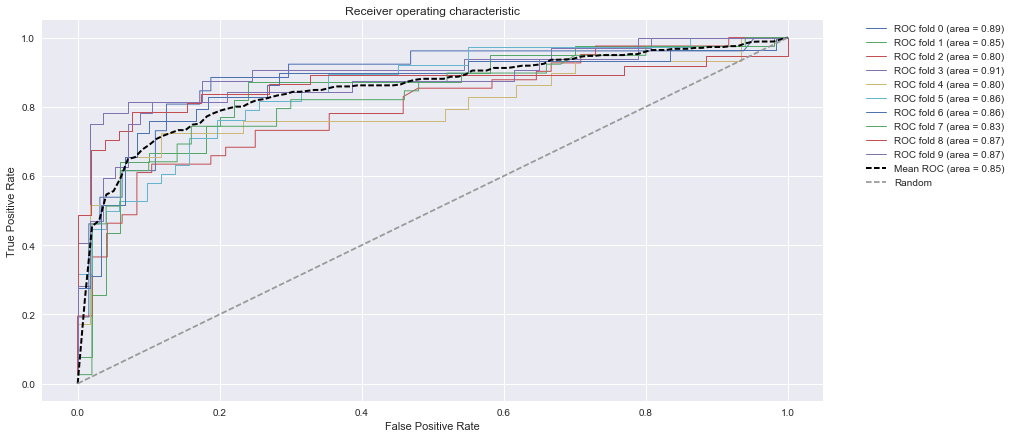

In [40]:
# K-folder下的ROC曲线和AUC面积（area）
titanic.plot_roc_estimator()

## 2.4 回归模型

#### 评估指标

In [41]:
def mean_absolute_error(y, y_pred):
     return np.average(np.abs(y - y_true), axis=0)

In [42]:
def median_absolute_error(y, y_pred):
     return np.median(np.abs(y - y_pred))

In [43]:
def mean_squared_error(y, y_pred):
     return np.average((y_true - y_pred) ** 2, axis=0)

In [44]:
def r2_score(y, y_pred):
    sse = ((y - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    sst = ((y - np.average(y, axis=0)) ** 2).sum(axis=0, dtype=np.float64)
    # 特殊值处理
    if sse == 0.0:
        if sst == 0.0:
            return 1.0
        else:
            return 0.0
    return 1 - sse / sst

### 波士顿房价预测

In [45]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from abupy import AbuML

# 数据集
scikit_boston = datasets.load_boston()
x = scikit_boston.data
y = scikit_boston.target
df = pd.DataFrame(data=np.c_[x, y], columns=np.append(scikit_boston.feature_names, ['MEDV']))
df.head(1)

/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.0063,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0


In [46]:
# 检查缺失
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# 归一化数据
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

# 模型训练
df = pd.DataFrame(data=np.c_[x_train, y_train], columns=np.append(scikit_boston.feature_names, ['MEDV']))
boston = AbuML(x_train, y_train, df)
boston.estimator.polynomial_regression(degree=1)
reg = boston.fit()

In [48]:
# 测试集上预测
y_pred = reg.predict(x_test)

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.75939114540128749

In [49]:
# 平方展开
boston.estimator.polynomial_regression(degree=2)

reg = boston.fit()
y_pred = reg.predict(x_test)
r2_score(y_test, y_pred)

-3.5506122975966448e+23

In [50]:
# 立方展开，r2很差时会变成负数
boston.estimator.polynomial_regression(degree=3)

reg = boston.fit()
y_pred = reg.predict(x_test)
r2_score(y_test, y_pred)

-1208.3117612353296

### 泰坦尼克号生存预测：回归预测特征“年龄”

In [51]:
import pandas as pd

data_train = pd.read_csv("./data/titanic/train.csv")
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


/Users/maxmon/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


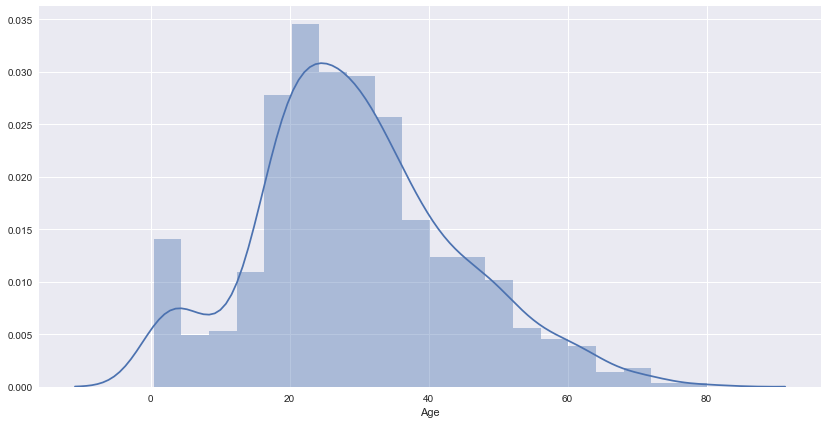

In [52]:
import seaborn as sns # seaborn包含了一系列的统计图形函数

sns.distplot(data_train["Age"].dropna(), kde=True, hist=True)

/Users/maxmon/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


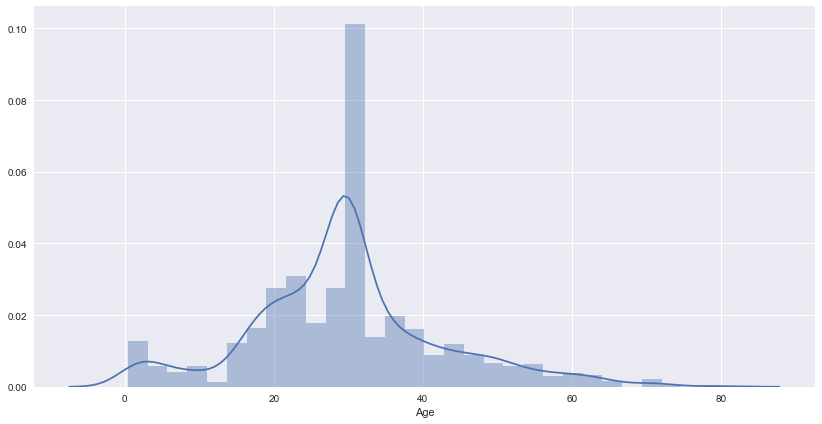

In [53]:
def set_missing_ages(p_df):
    """均值特征填充"""
    p_df.loc[(p_df.Age.isnull()), 'Age'] = data_train.Age.dropna().mean()
    return p_df

data_train = set_missing_ages(data_train)
data_train_fix1 = set_missing_ages(data_train)
sns.distplot(data_train_fix1["Age"], kde=True, hist=True)

/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+

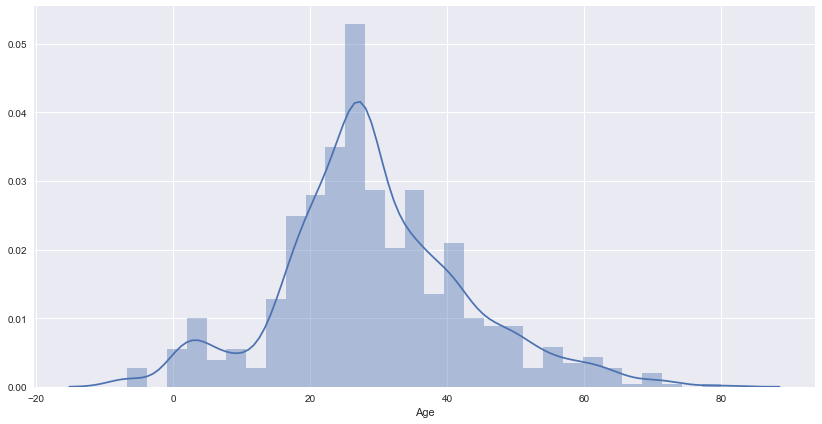

In [54]:
from abupy import AbuML
import sklearn.preprocessing as preprocessing

def set_missing_ages2(p_df):
    """回归模型预测特征填充"""
    age_df = p_df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
    # 归一化
    scaler = preprocessing.StandardScaler()
    age_df['Fare_scaled'] = scaler.fit_transform(age_df['Fare'])
    del age_df['Fare']
    # 分割已经数据和待预测数据集
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    y_inner = known_age[:, 0]
    x_inner = known_age[:, 1:]
    # 训练
    rfr_inner = AbuML(x_inner, y_inner, age_df.Age.notnull())
    rfr_inner.estimator.polynomial_regression(degree=1)
    reg_inner = rfr_inner.fit()
    # 预测
    predicted_ages = reg_inner.predict(unknown_age[:, 1::])
    p_df.loc[(p_df.Age.isnull()), 'Age'] = predicted_ages
    return p_df

data_train = pd.read_csv('./data/titanic/train.csv')
data_train_fix2 = set_missing_ages2(data_train)
sns.distplot(data_train_fix2["Age"], kde=True, hist=True)

In [55]:
# 处理cabin特征
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df

def train_val(data):
    """封装所有处理训练步骤"""
    # 处理离散特征
    dummies__cabin = pd.get_dummies(data['Cabin'], prefix='Cabin')
    dummies__embarked = pd.get_dummies(data['Embarked'], prefix='Embarked')
    dummies__sex = pd.get_dummies(data['Sex'], prefix='Sex')
    dummies__pclass = pd.get_dummies(data['Pclass'], prefix='Pclass')
    df = pd.concat([data, dummies__cabin, dummies__embarked, dummies__sex, dummies__pclass], axis=1)
    df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
    # 归一化数据
    scaler = preprocessing.StandardScaler()
    df['Age_scaled'] = scaler.fit_transform(df['Age'])
    df['Fare_scaled'] = scaler.fit_transform(df['Fare'])
    df['SibSp_scaled'] = scaler.fit_transform(df['SibSp'])
    df['Parch_scaled'] = scaler.fit_transform(df['Parch'])
    # 选择特征
    train_df = df.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
    train_np = train_df.as_matrix()
    y = train_np[:, 0]
    x = train_np[:, 1:]
    titanic = AbuML(x, y, train_df)
    titanic.estimator.logistic_classifier()
    titanic.cross_val_accuracy_score()

In [56]:
data_train_fix1 = set_cabin_type(data_train_fix1)
train_val(data_train_fix1)

/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
LogisticRegress

In [57]:
data_train_fix2 = set_cabin_type(data_train_fix2)
train_val(data_train_fix2)

/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
LogisticRegress

## 2.5 决策树模型

### 信息与编码


In [58]:
import numpy as np

def entropy(P):
    """根据每个样本出现的概率，计算信息量，输入P是数据集上每个数值统计的频率（概率）向量"""
    return -np.sum(P * np.log2(P))

### 对比线性模型和决策树模型的表现

In [59]:
from abupy import AbuML
import sklearn.preprocessing as preprocessing
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def set_missing_ages(p_df):
    age_df = p_df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
    # 归一化
    scaler = preprocessing.StandardScaler()
    age_df['Fare_scaled'] = scaler.fit_transform(age_df['Fare'])
    del age_df['Fare']
    # 分割已经数据和待预测数据集
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    y_inner = known_age[:, 0]
    x_inner = known_age[:, 1:]
    rfr_inner = AbuML(x_inner, y_inner, age_df.Age.notnull())
    rfr_inner.estimator.polynomial_regression(degree=1)
    reg_inner = rfr_inner.fit()
    predicted_ages = reg_inner.predict(unknown_age[:, 1::])
    p_df.loc[(p_df.Age.isnull()), 'Age'] = predicted_ages
    return p_df

# 处理cabin特征
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df

data_train = pd.read_csv('./data/titanic/train.csv')
# 处理数据缺失
data_train = set_missing_ages(data_train)
data_train = set_cabin_type(data_train)

# 处理离散特征
dummies__cabin = pd.get_dummies(data_train['Cabin'], prefix='Cabin')
dummies__embarked = pd.get_dummies(data_train['Embarked'], prefix='Embarked')
dummies__sex = pd.get_dummies(data_train['Sex'], prefix='Sex')
dummies__pclass = pd.get_dummies(data_train['Pclass'], prefix='Pclass')
df = pd.concat([data_train, dummies__cabin, dummies__embarked, dummies__sex, dummies__pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

# 归一化数据
scaler = preprocessing.StandardScaler()
df['Age_scaled'] = scaler.fit_transform(df['Age'])
df['Fare_scaled'] = scaler.fit_transform(df['Fare'])
df['SibSp_scaled'] = scaler.fit_transform(df['SibSp'])
df['Parch_scaled'] = scaler.fit_transform(df['Parch'])

# 选择特征
train_df = df.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]

titanic = AbuML(x, y, train_df)

/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if

In [60]:
titanic.estimator.logistic_classifier()
titanic.cross_val_accuracy_score()

LogisticRegression score mean: 0.8091839745772329


array([ 0.8333,  0.8111,  0.7865,  0.8427,  0.8202,  0.7753,  0.7865,
        0.809 ,  0.809 ,  0.8182])

start grid search please wait...


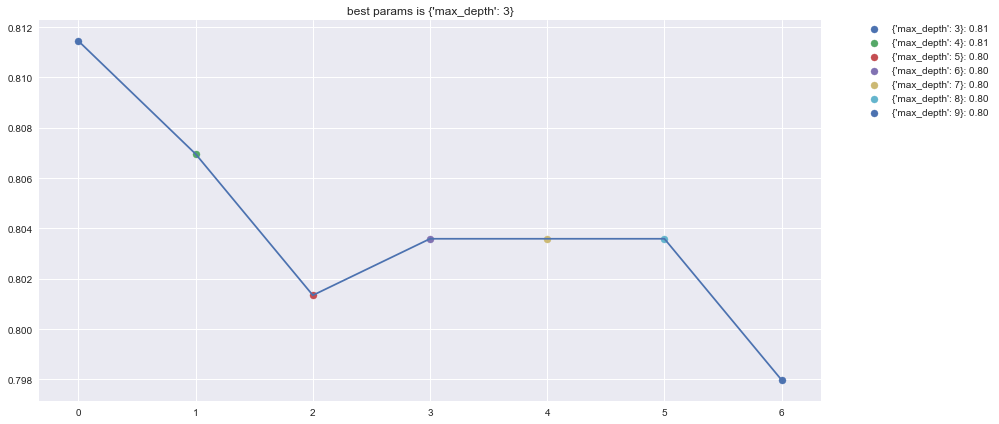

(0.81144781144781142, {'max_depth': 3})

In [61]:
# 切换决策树
titanic.estimator.decision_tree_classifier(criterion='entropy')
# grid seach寻找最优的决策树层数
param_grid = dict(max_depth=range(3, 10))

best_score_, best_params_ = ABuMLGrid.grid_search_mul_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,                                                                      param_grid=param_grid, show=True)
best_score_, best_params_

In [62]:
titanic.estimator.decision_tree_classifier(criterion='entropy', **best_params_)
titanic.cross_val_accuracy_score()

DecisionTreeClassifier score mean: 0.811443366246737


array([ 0.8111,  0.8111,  0.7865,  0.8539,  0.8202,  0.7978,  0.7978,
        0.7865,  0.8427,  0.8068])

In [ ]:
# 这段代码依赖python的pydot和graphviz包
from sklearn import tree
import pydot 
from sklearn.externals.six import StringIO

# 为了方便试图，这里限制决策树的深度观察
titanic.estimator.decision_tree_classifier(criterion='entropy', max_depth=3)
clf = titanic.fit()

# 存储树plot
dotfile = StringIO()
tree.export_graphviz(clf, out_file=dotfile, feature_names=titanic.df.columns[1:])
pydot.graph_from_dot_data(dotfile.getvalue()).write_png("dtree2.png")
!open dtree2.png

## 2.6 模型融合

### 融合成群体(Ensamble)

### Bagging：随机森林(Random Forest)

In [63]:
from abupy import AbuML
import sklearn.preprocessing as preprocessing
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def set_missing_ages(p_df):
    p_df.loc[(p_df.Age.isnull()), 'Age'] = data_train.Age.dropna().mean()
    return p_df

# 处理cabin特征
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df

data_train = pd.read_csv('./data/titanic/train.csv')
data_train = set_missing_ages(data_train)
data_train = set_cabin_type(data_train)
# 处理离散特征
dummies__cabin = pd.get_dummies(data_train['Cabin'], prefix='Cabin')
dummies__embarked = pd.get_dummies(data_train['Embarked'], prefix='Embarked')
dummies__sex = pd.get_dummies(data_train['Sex'], prefix='Sex')
dummies__pclass = pd.get_dummies(data_train['Pclass'], prefix='Pclass')
df = pd.concat([data_train, dummies__cabin, dummies__embarked, dummies__sex, dummies__pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
# 归一化数据
scaler = preprocessing.StandardScaler()
df['Age_scaled'] = scaler.fit_transform(df['Age'])
df['Fare_scaled'] = scaler.fit_transform(df['Fare'])
df['SibSp_scaled'] = scaler.fit_transform(df['SibSp'])
df['Parch_scaled'] = scaler.fit_transform(df['Parch'])
# 选择特征
train_df = df.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
titanic = AbuML(x, y, train_df)

/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/maxmon/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


start grid search please wait...


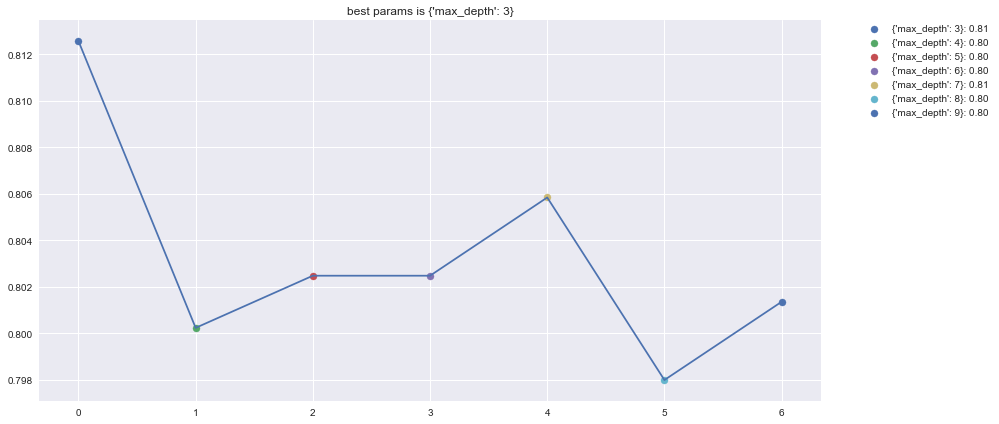

DecisionTreeClassifier score mean: 0.8125800136193394


array([ 0.8111,  0.8222,  0.7753,  0.8539,  0.8202,  0.7753,  0.7978,
        0.7865,  0.8539,  0.8295])

In [64]:
# 决策树
titanic.estimator.decision_tree_classifier()
# grid seach寻找最优的决策树层数
param_grid = dict(max_depth=range(3, 10))
_, best_params = ABuMLGrid.grid_search_mul_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
                                                                       param_grid=param_grid, show=True)

titanic.estimator.decision_tree_classifier(**best_params_)
titanic.cross_val_accuracy_score()

start grid search please wait...


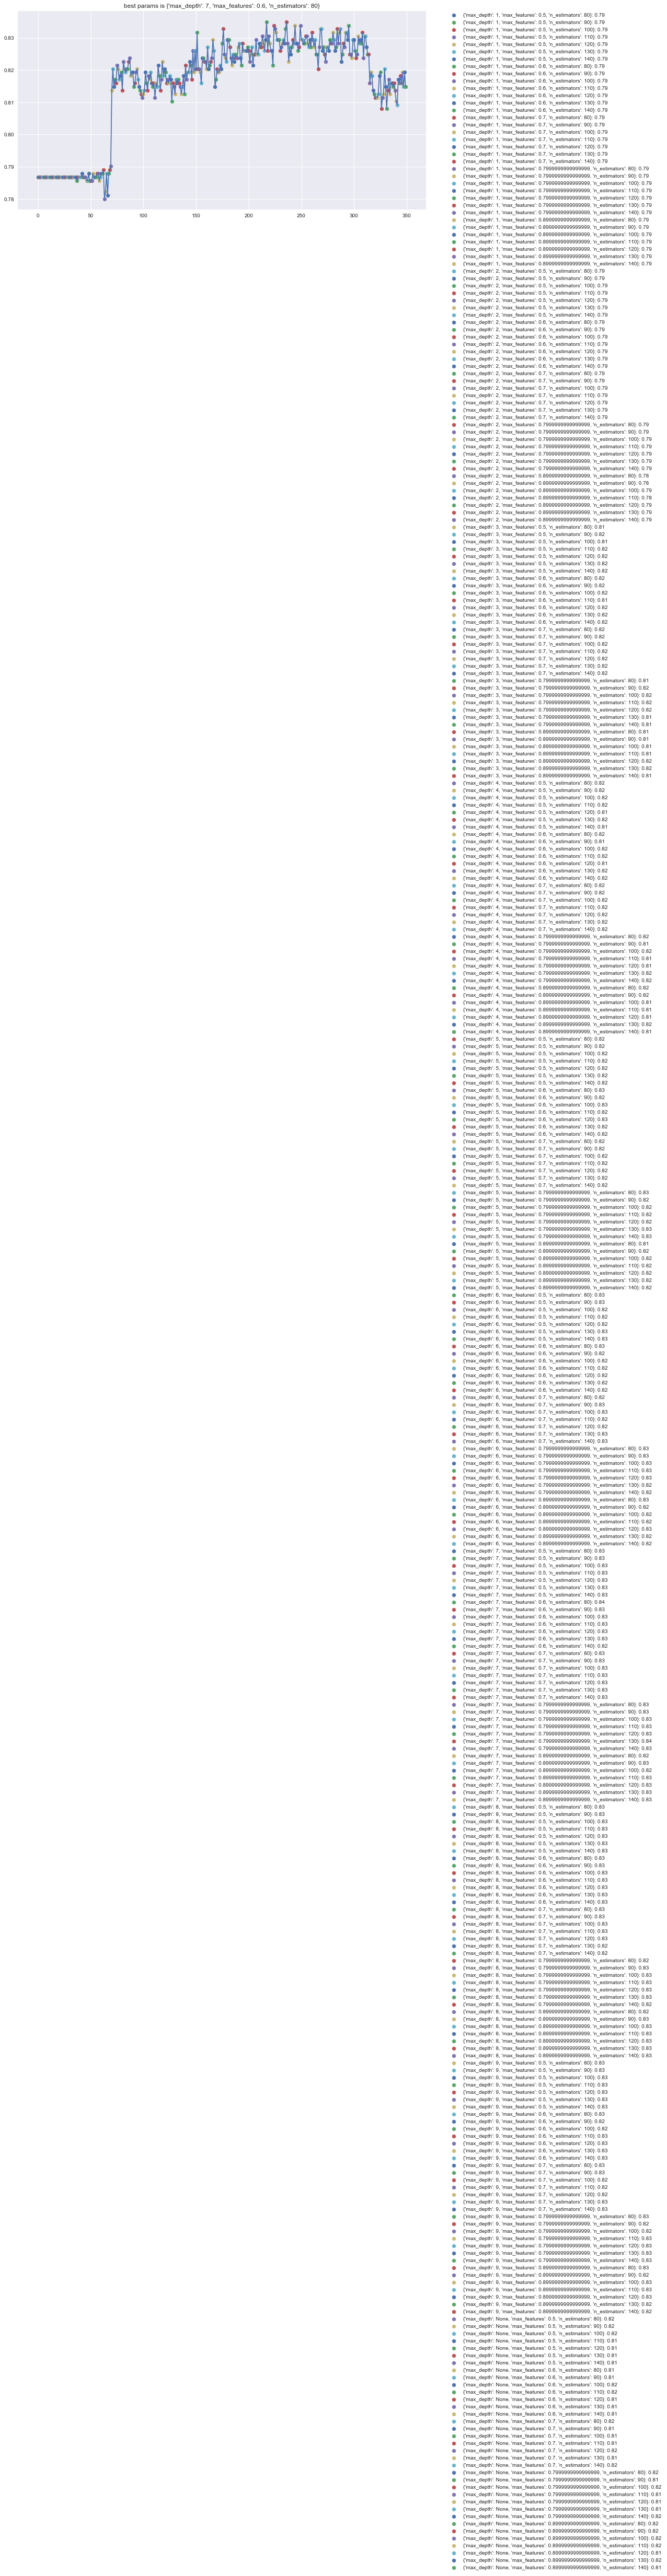

(0.83501683501683499,
 {'max_depth': 7, 'max_features': 0.6, 'n_estimators': 80})

In [65]:
# 随机森林
titanic.estimator.random_forest_classifier()
# grid seach寻找最优的参数：n_estimators个体模型数量；max_features特征集子集样本比例；max_depth层数深度
param_grid = {
    'n_estimators': range(80, 150, 10),
    'max_features': np.arange(.5, 1.,.1).tolist(),
    'max_depth': list(range(1, 10)) + [None]
}
# n_jobs=-1开启多线程
best_score_, best_params_ = ABuMLGrid.grid_search_mul_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
                                                                       param_grid=param_grid, show=True, n_jobs=-1)
best_score_, best_params_

In [66]:
titanic.estimator.random_forest_classifier(**best_params_)
titanic.cross_val_accuracy_score()

RandomForestClassifier score mean: 0.8261766541822719


array([ 0.7889,  0.7889,  0.7528,  0.8427,  0.9101,  0.8315,  0.8202,
        0.7865,  0.8652,  0.875 ])

### Boosting：GBDT

start grid search please wait...


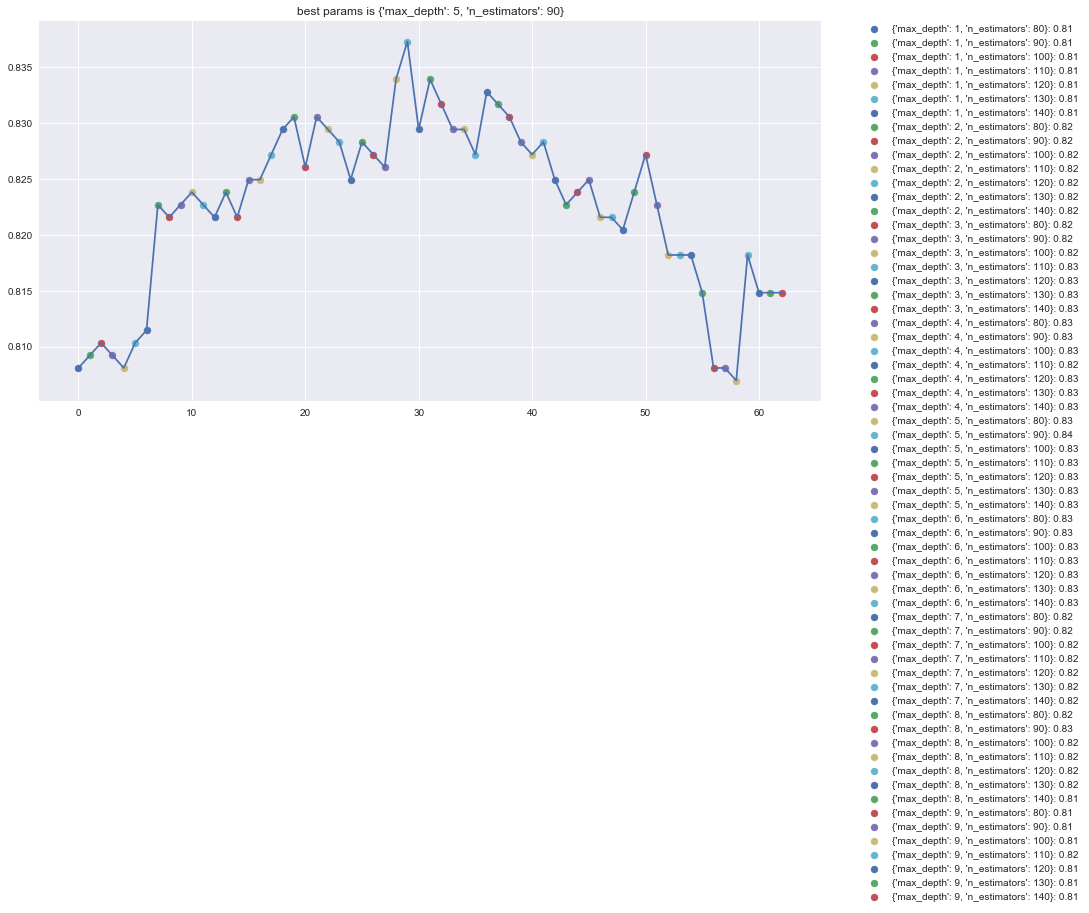

(0.83726150392817056, {'max_depth': 5, 'n_estimators': 90})

In [67]:
# GBDT
titanic.estimator.xgb_classifier()

# grid seach寻找最优的参数：n_estimators个体模型数量；max_depth层数深度
param_grid = {
    'n_estimators': range(80, 150, 10),
    'max_depth': range(1, 10)
}

# n_jobs=-1开启多线程
best_score_, best_params_ = ABuMLGrid.grid_search_mul_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
                                                                       param_grid=param_grid, show=True, n_jobs=-1)
best_score_, best_params_

In [68]:
titanic.estimator.xgb_classifier(**best_params_)
titanic.cross_val_accuracy_score()

GradientBoostingClassifier score mean: 0.831731926001589


array([ 0.7778,  0.8444,  0.7528,  0.8764,  0.8989,  0.7978,  0.8202,
        0.7978,  0.8876,  0.8636])

### Stacking

In [68]:
# 逻辑分类
titanic.estimator.logistic_classifier()
titanic.cross_val_accuracy_score()

LogisticRegression score mean: 0.806974804222


array([ 0.8222,  0.8111,  0.7753,  0.8315,  0.809 ,  0.764 ,  0.7865,
        0.7978,  0.8315,  0.8409])

In [69]:
# 随机森林
param = {'max_depth': 8, 'max_features': 0.6, 'n_estimators': 80}
titanic.estimator.random_forest_classifier(**param)
titanic.cross_val_accuracy_score()

RandomForestClassifier score mean: 0.835140165702


array([ 0.7889,  0.8   ,  0.764 ,  0.8652,  0.9213,  0.8427,  0.809 ,
        0.809 ,  0.8876,  0.8636])

In [70]:
# GBDT
param = {'max_depth': 5, 'n_estimators': 140}
titanic.estimator.xgb_classifier(**param)
titanic.cross_val_accuracy_score()

GradientBoostingClassifier score mean: 0.826075644081


array([ 0.7778,  0.8444,  0.7528,  0.8764,  0.8764,  0.7865,  0.809 ,
        0.809 ,  0.8989,  0.8295])

In [71]:
# 准备训练好的模型
titanic.estimator.logistic_classifier()
lr = titanic.fit()
param = {'max_depth': 8, 'max_features': 0.6, 'n_estimators': 80}
titanic.estimator.random_forest_classifier(**param)
rf = titanic.fit()
param = {'max_depth': 5, 'n_estimators': 140}
titanic.estimator.xgb_classifier(**param)
gbdt = titanic.fit()

# 构造stacking训练集，融合三个模型的预测的概率值作为特征数据
x_stk = np.array([lr.predict_proba(x)[:, 0], rf.predict_proba(x)[:, 0], gbdt.predict_proba(x)[:, 0]]).T
x_df_stk = pd.DataFrame(x_stk, columns=['lr', 'rf', 'gbdt'])
y_df = pd.DataFrame(y, columns=['y'])
df = y_df.join(x_df_stk)

# stacking模型
stackings = AbuML(x_stk, y, df)

stackings.estimator.logistic_classifier()

# 获得titanic的融合模型stk
stk = stackings.fit()

#### 一个常见的错误

In [72]:
stackings.cross_val_accuracy_score()

LogisticRegression score mean: 0.97081091817


array([ 0.9667,  0.9889,  0.9326,  0.9775,  0.9663,  0.9775,  0.9775,
        0.9551,  0.9888,  0.9773])

In [73]:
from abupy import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

def lr_model(x_train, x_test, y_train, y_test):
    """返回训练好的逻辑分类模型及分数"""
    lr = LogisticRegression(C=1.0)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    return lr, metrics.accuracy_score(y_test, y_pred)

def rf_model(x_train, x_test, y_train, y_test):
    """返回训练好的随机森林模型及分数"""
    param_grid = {
    'n_estimators': range(80, 120, 10),
    'max_features': np.arange(.6, .9,.1).tolist(),
    'max_depth': list(range(3, 9)) + [None]
    }
    
    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    rf = RandomForestClassifier(**grid.best_params_)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    return rf, metrics.accuracy_score(y_test, y_pred)

def gbdt_model(x_train, x_test, y_train, y_test):
    """返回训练好的GBDT模型及分数"""
    param_grid = {
    'n_estimators': list(range(80, 120, 10)),
    'max_features': np.arange(.6, .9,.1).tolist(),
    'max_depth': list(range(3, 9)) + [None]
    }
    
    grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    gbdt = GradientBoostingClassifier(**grid.best_params_)
    gbdt.fit(x_train, y_train)
    y_pred = gbdt.predict(x_test)
    return gbdt, metrics.accuracy_score(y_test, y_pred)

def stack_models(x_train, x_test, y_train, y_test):
    """返回融合后的模型及分数"""
    param_grid = {
    'C': [.01, .1, 1, 10]
    }
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    stk = LogisticRegression(penalty='l1', tol=1e-6, **grid.best_params_)
    stk.fit(x_train, y_train)
    y_pred = stk.predict(x_test)
    return rf, metrics.accuracy_score(y_test, y_pred)

kf = KFold(len(titanic.y), n_folds=5, shuffle=True)
lr_scores = []
rf_scores = []
gbdt_scores = []
stk_scores = []

for train_index, test_index in kf:
    x_train, x_test = titanic.x[train_index], titanic.x[test_index]
    y_train, y_test = titanic.y[train_index], titanic.y[test_index]
    
    # 单个模型成绩
    lr, lr_score = lr_model(x_train, x_test, y_train, y_test)
    rf, rf_score = rf_model(x_train, x_test, y_train, y_test)
    gbdt, gbdt_score = gbdt_model(x_train, x_test, y_train, y_test)
    
    # stacking
    x_train_stk = np.array([lr.predict_proba(x_train)[:, 0], rf.predict_proba(x_train)[:, 0], gbdt.predict_proba(x_train)[:, 0]]).T
    x_test_stk = np.array([lr.predict_proba(x_test)[:, 0], rf.predict_proba(x_test)[:, 0], gbdt.predict_proba(x_test)[:, 0]]).T
    stk, stk_score = stack_models(x_train_stk, x_test_stk, y_train, y_test)
    
    # append score
    lr_scores.append(lr_score)
    rf_scores.append(rf_score)
    gbdt_scores.append(gbdt_score)
    stk_scores.append(stk_score)
    
print('lr mean score: {}'.format(np.mean(lr_scores)))
print('rf mean score: {}'.format(np.mean(rf_scores)))
print('gbdt mean score: {}'.format(np.mean(gbdt_scores)))
print('stk mean score: {}'.format(np.mean(stk_scores)))

lr mean score: 0.796924235767
rf mean score: 0.828290753876
gbdt mean score: 0.818197225535
stk mean score: 0.815962588664


In [74]:
print('lr std score: {}'.format(np.std(lr_scores)))
print('rf std score: {}'.format(np.std(rf_scores))) 
print('gbdt std score: {}'.format(np.std(gbdt_scores)))
print('stk std score: {}'.format(np.std(stk_scores)))

lr std score: 0.0318974145841
rf std score: 0.00964101533879
gbdt std score: 0.0133452276808
stk std score: 0.0120748278128


In [75]:
rf_scores

[0.82122905027932958,
 0.84269662921348309,
 0.8314606741573034,
 0.8146067415730337,
 0.8314606741573034]

In [76]:
gbdt_scores

[0.8044692737430168,
 0.8202247191011236,
 0.84269662921348309,
 0.8089887640449438,
 0.8146067415730337]

In [77]:
stk_scores

[0.79329608938547491,
 0.8146067415730337,
 0.8258426966292135,
 0.8258426966292135,
 0.8202247191011236]

In [78]:
import numpy as np

def three_kfolder(data, n_folds=5, shuffle=True, ratios=[4, 1, 2]):
    """按ratios数组随机(shuffle)三分割数据集，返回：traing_set, stacking_set, testing_set"""
    assert ratios and len(ratios) == 3, 'ratios必须是3-items-arraylike数组'
    data = np.array(data)
    N = len(data)
    ratios_nor = np.array(ratios).astype(float) / np.sum(ratios)
    ratios_num = (ratios_nor * N).astype(int).cumsum()

    for i in range(n_folds):
        ind = list(range(len(data)))
        np.random.shuffle(ind)
        data_shuf = data[ind]
        yield data_shuf[:ratios_num[0]], data_shuf[ratios_num[0]:ratios_num[1]], data_shuf[ratios_num[1]:ratios_num[2]]

# 使用demo   
data = ['a', 'c', 'd', 'e', 'g', '2','f', 'c','3', 'p']
for traing_set, stacking_set, testing_set in three_kfolder(data):
    print(traing_set)
    print(stacking_set)
    print(testing_set)

['c' 'c' 'g' '2' 'a']
['p']
['e' 'd']
['d' 'g' 'f' 'c' 'e']
['a']
['p' '3']
['a' '2' 'e' 'd' 'p']
['f']
['c' 'g']
['2' 'd' 'c' 'g' 'p']
['c']
['e' '3']
['c' '2' '3' 'a' 'd']
['f']
['c' 'e']
